In [26]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
if not "milligrad" in os.listdir():
    os.chdir('..')

from milligrad import Tensor, Module, Adam, topological_sort
from extras.mnist import load_mnist_data

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# flattening images and one-hot encoding labels
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

# normalizing
mean, std = x_train.mean(), x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std


In [28]:
from milligrad.tensor import Tensor
        
class MLP(Module):
    def __init__(self):
        super().__init__()
        self.w1 = Tensor.xavier(784, 128)
        self.b1 = Tensor.randn(128)
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor)->Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2
    
    def parameters(self)->list[Tensor]:
        return [self.w1, self.b1, self.w2, self.b2]

In [29]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [30]:
model = MLP()
optim = Adam(model.parameters(), lr=1e-3)

losses = []
accuracies = []
for i in range(100):
    y_hat = model(Tensor(x_train[:100]))
    loss = y_hat.cross_entropy(Tensor(y_train[:100]))
    # loss = ((x_hat - Tensor(x_train[:100]))**2).sum().mean()
    losses.append(loss.data)
    accuracies.append(accuracy(y_train[:100], y_hat.data))
    
    optim.zero_grad()
    loss.backward()
    optim.step()
        

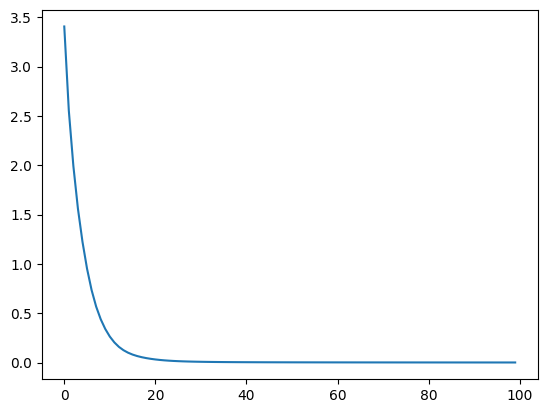

In [31]:
plt.plot(losses)

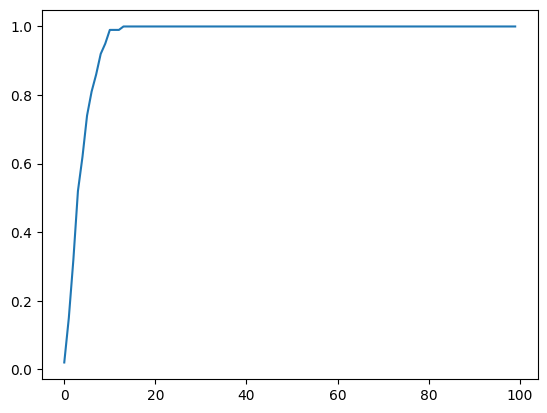

In [32]:
plt.plot(accuracies)

2


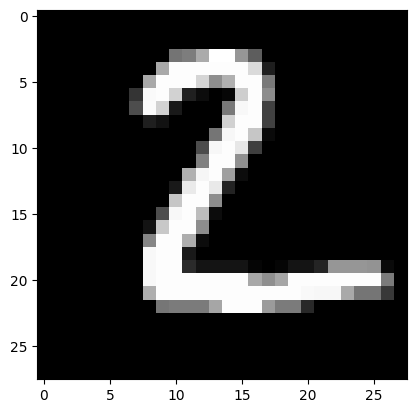

In [37]:
print(model(Tensor(x_test[1])).data.argmax())

plt.imshow(x_test[1].reshape(28, 28), cmap='gray')

In [34]:
img = x_hat.data[5].reshape(28, 28)
img = (img * (train_max - train_min)) + train_min

plt.imshow(img, cmap="gray")

NameError: name 'x_hat' is not defined